In [2]:
from functools import partial

from transformer_lens import HookedTransformer
from IPython.display import SVG

import diego as d
from utils import sankey_diagram_of_connectome

%load_ext autoreload
%autoreload 2

In [3]:
model = HookedTransformer.from_pretrained("gpt2-small")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
# model = HookedTransformer.from_pretrained("attn-only-4l")

0it [00:00, ?it/s]

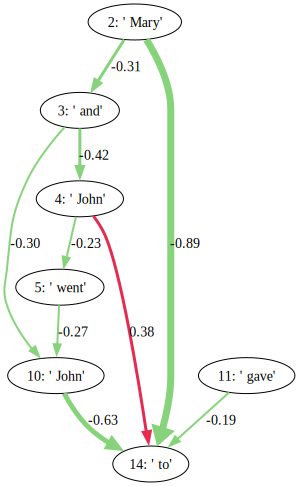

In [39]:
threshold = 0.15
prompt = "When Mary and John went to the store, John gave a book to"
corrupt_prompt = "When Tom and Sarah went to the store, Felix gave a book to"

c = d.connectom(model, prompt,
          d.logit_diff_metric(model, ' Mary', ' John'),
          d.ZeroPattern(),
          # d.CorruptIntervention(model, prompt, corrupt_prompt),
          # d.BasicStrategy(),
          # d.BacktrackBisectStrategy(threshold),
          strategy=d.BacktrackingStrategy(threshold),
          # strategy=d.BisectStrategy(threshold),
)
# sankey_diagram_of_connectome(model, prompt, c, threshold=threshold);
d.plot_attn_connectome(model, prompt, c).show()
graph = d.plot_graphviz_connectome(model, prompt, c, threshold=threshold).pipe('svg').decode('utf-8')
SVG(graph)

  0%|          | 0/105 [00:00<?, ?it/s]

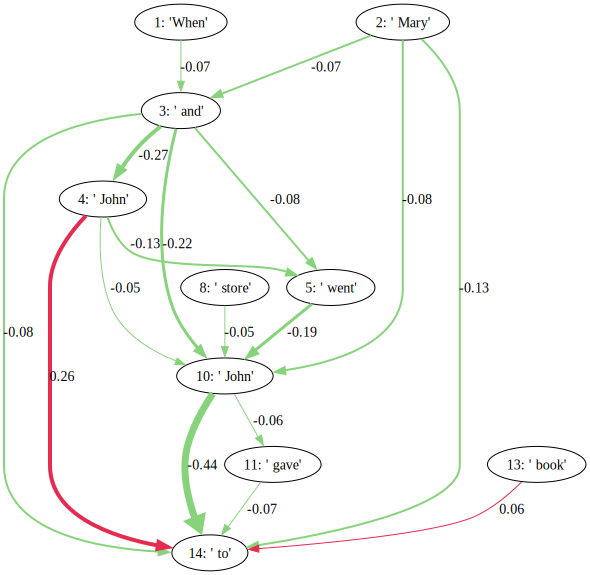

In [41]:
dampening = 0.25
c = d.connectom(model, prompt,
          d.logit_diff_metric(model, ' Mary', ' John'),
          # d.CorruptIntervention(model, prompt, corrupt_prompt),
          d.DampenIntervention(dampening),
          # d.ZeroPattern(),
          d.BasicStrategy(),
          )
d.plot_attn_connectome(model, prompt, c).show()
graph = d.plot_graphviz_connectome(model, prompt, c, threshold=0.05).pipe('svg').decode('utf-8')
SVG(graph)